# **Creating Word Embeddings**

In [1]:
import torch
from transformers import BertModel, BertTokenizer, XLNetModel, XLNetTokenizer, T5EncoderModel, T5Tokenizer
from sklearn.model_selection import train_test_split
import re
import os
import requests
import gc
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# If CUDA is available, we will fetch the name of the CUDA device, otherwise we will return a message stating CUDA is not available.
cuda_device_info = torch.cuda.get_device_name(0) if cuda_available else "CUDA is not available."

cuda_available, cuda_device_info

(True, 'Tesla T4')

## **Functions to Extract Word Embeddings**

In [3]:
class LM_EMBED:

  def __init__(self, language_model, max_len, rare_aa):
    self.lang_model = language_model
    self.max_len = max_len
    self.rare_aa = rare_aa

    # Import tokenizer and model from ProtTrans Pre-Trained Rostlab:
    if self.lang_model == 'BERT-BFD':
      self.tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert_bfd', do_lower_case=False)
      self.model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
    elif self.lang_model == 'BERT':
      self.tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
      self.model = BertModel.from_pretrained("Rostlab/prot_bert")
    elif self.lang_model == 'T5-XL-BFD':
      self.tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", do_lower_case=False )
      self.model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_bfd")
      gc.collect()
    elif self.lang_model == 'T5-XL-UNI':
      self.tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
      self.model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
      gc.collect()
    elif self.lang_model == 'XLNET':
      self.tokenizer = XLNetTokenizer.from_pretrained("Rostlab/prot_xlnet", do_lower_case=False)
      self.model = XLNetModel.from_pretrained("Rostlab/prot_xlnet", mem_len=512)


  # Function to use the specified model and tokenizer to create word embedding array:
  def extract_word_embs(self, seq_df, filename):

    # Setting device to GPU if available:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    # Assigning model to GPU if available, and setting to eval mode:
    self.model = self.model.to(device)
    self.model = self.model.eval()

    # Making a list of sequences from the df:
    seqs_list = seq_df.Sequence.to_list()

    # Adding spaces in between sequence letters (amino acids):
    seqs_spaced = self.add_spaces(seqs_list)

    # Map Rarely Occuring Amino Acids (U, Z, O, B) to (X) if they are present in the dataset:
    if self.rare_aa:
      seqs_spaced = [re.sub(r"[UZOB]", "X", sequence) for sequence in seqs_spaced]

    # ID list tokenized:
    ids = self.tokenizer.batch_encode_plus(seqs_spaced, add_special_tokens=True, padding = 'max_length', max_length = self.max_len)

    # Retrieving the input IDs and mask for attention as tensors:
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)

    # Emptying cache to ensure enough memory:
    torch.cuda.empty_cache()

    # Loop to process the sequences into embeddings in batches of 10:
    for i in range(10, len(input_ids)+10, 10):
      if i%100 == 0:
        print("Initial Embedding Batch Ending with...", i)
      with torch.no_grad():
        embeddings = self.model(input_ids=input_ids[i-10:i], 
                                attention_mask=attention_mask[i-10:i])[0]
        emb_array = embeddings.cpu().numpy()

        # Creating initial array or concatenating to existing array:
        if i==10:
          embedding_res = emb_array
        else:
          embedding_res = np.concatenate((embedding_res, emb_array))

    # Extracting features using the function below:
    features = self.extract_features(embedding_res, attention_mask) 

    # Padding these features to a specified max length with zeros:
    padded_arr = self.pad(features)

    #Ensuring in correct location to save embeddings:
    #%cd "INSERT_EMBEDDINGS_FOLDER_LOC"

    # Saving array:
    print("Saving Embeddings...")
    np.save(filename, padded_arr)


  # Function to add spaces between the amino acids in each sequence:
  def add_spaces(self, df_col):
    return [" ".join(x) for x in df_col]

  # Function to remove any CLS or SEP tokens, just leaving features:
  def extract_features(self, emb_res, att_msk):
    features = [] 

    for seq_num in range(len(emb_res)):
      seq_len = (att_msk[seq_num] == 1).sum()

      if self.lang_model in ['BERT-BFD', 'BERT']:
        seq_emd = emb_res[seq_num][1:seq_len-1]

      elif self.lang_model in ['T5-XL-BFD', 'T5-XL-UNI']:
        seq_emd = emb_res[seq_num][:seq_len-1]

      elif self.lang_model == 'XLNET':
        padded_seq_len = len(att_msk[seq_num])
        seq_emd = emb_res[seq_num][padded_seq_len-seq_len:padded_seq_len-2]

      features.append(seq_emd)
    
    features_arr = np.array(features, dtype=object)

    return features_arr

  # Function to add zeros to pad all features to max length:
  def pad(self, features):
    dim1 = self.max_len-2   # reducing by 2 for CLS and SEP tokens which have already been removed
    dim2 = features[0].shape[1]

    for i in range(len(features)):
      if i%100 == 0:
        print("Padding Batch: ", i)

      all_zeros = np.zeros((dim1, dim2))
      all_zeros[:features[i].shape[0], :features[i].shape[1]] = features[i]

      if i==0:
        padded_arr = all_zeros
      elif i==1:
        padded_arr = np.stack((padded_arr, all_zeros), axis=0)
      else:
        reshaped_arr = all_zeros.reshape(1, all_zeros.shape[0], all_zeros.shape[1])
        padded_arr = np.vstack((padded_arr, reshaped_arr))
    
    return padded_arr

## **Loading Dataset**

In [ ]:
X_train = pd.read_csv('Dataset/Original Dataset/neuro-peptide-data-files/train.csv')
y_train = X_train.drop(['Sequence'], axis=1)
X_train.drop(['Label'], axis=1, inplace=True)

X_val = pd.read_csv('Dataset/Original Dataset/neuro-peptide-data-files/val.csv')
y_val = X_val.drop(['Sequence'], axis=1)
X_val.drop(['Label'], axis=1, inplace=True)

X_test = pd.read_csv('Dataset/Original Dataset/neuro-peptide-data-files/test.csv')
y_test = X_test.drop(['Sequence'], axis=1)
X_test.drop(['Label'], axis=1, inplace=True)

## **Generating Embeddings**

In [9]:
# Specifying the max sequence length in the given dataset (255 for the LMPred Dataset), 
# then adding 2 to account for special [CLS, SEP] tokens added by the language models):
max_seq_len = 102

# BERT_BFD_EMBED = LM_EMBED('BERT-BFD', max_seq_len, True)
# BERT_EMBED = LM_EMBED('BERT', max_seq_len, True)
# T5XL_BFD_EMBED = LM_EMBED('T5-XL-BFD', max_seq_len, True)
# T5XL_UNI_EMBED = LM_EMBED('T5-XL-UNI', max_seq_len, True)
XLNET_EMMBED = LM_EMBED('XLNET', max_seq_len, True)

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.64G [00:00<?, ?B/s]

In [10]:
# BERT_BFD_EMBED.extract_word_embs(X_train, "/kaggle/working/BERT_BFD_EMBED_X_TRAIN.npy")
# BERT_BFD_EMBED.extract_word_embs(X_val, "/kaggle/working/BERT_BFD_EMBED_X_VAL.npy")
# BERT_BFD_EMBED.extract_word_embs(X_test, "/kaggle/working/BERT_BFD_EMBED_X_TEST.npy")

In [11]:
# BERT_EMBED.extract_word_embs(X_train, "/kaggle/working/BERT_EMBED_X_TRAIN.npy")
# BERT_EMBED.extract_word_embs(X_val, "/kaggle/working/BERT_EMBED_X_VAL.npy")
# BERT_EMBED.extract_word_embs(X_test, "/kaggle/working/BERT_EMBED_X_TEST.npy")

In [12]:
# T5XL_BFD_EMBED.extract_word_embs(X_train, "/kaggle/working/T5XL_BFD_EMBED_X_TRAIN.npy")
# T5XL_BFD_EMBED.extract_word_embs(X_val, "/kaggle/working/T5XL_BFD_EMBED_X_VAL.npy")
# T5XL_BFD_EMBED.extract_word_embs(X_test, "/kaggle/working/T5XL_BFD_EMBED_X_TEST.npy")

In [13]:
# T5XL_UNI_EMBED.extract_word_embs(X_train, "/kaggle/working/T5XL_UNI_EMBED_X_TRAIN.npy")
# T5XL_UNI_EMBED.extract_word_embs(X_val, "/kaggle/working/T5XL_UNI_EMBED_X_VAL.npy")
# T5XL_UNI_EMBED.extract_word_embs(X_test, "/kaggle/working/T5XL_UNI_EMBED_X_TEST.npy")

In [14]:
XLNET_EMMBED.extract_word_embs(X_train, "/kaggle/working/XLNET_EMMBED_X_TRAIN.npy")
XLNET_EMMBED.extract_word_embs(X_val, "/kaggle/working/XLNET_EMMBED_X_VAL.npy")
XLNET_EMMBED.extract_word_embs(X_test, "/kaggle/working/XLNET_EMMBED_X_TEST.npy")

cuda:0
Initial Embedding Batch Ending with... 100
Initial Embedding Batch Ending with... 200
Initial Embedding Batch Ending with... 300
Initial Embedding Batch Ending with... 400
Initial Embedding Batch Ending with... 500
Initial Embedding Batch Ending with... 600
Initial Embedding Batch Ending with... 700
Initial Embedding Batch Ending with... 800
Initial Embedding Batch Ending with... 900
Initial Embedding Batch Ending with... 1000
Initial Embedding Batch Ending with... 1100
Initial Embedding Batch Ending with... 1200
Initial Embedding Batch Ending with... 1300
Initial Embedding Batch Ending with... 1400
Initial Embedding Batch Ending with... 1500
Initial Embedding Batch Ending with... 1600
Initial Embedding Batch Ending with... 1700
Initial Embedding Batch Ending with... 1800
Initial Embedding Batch Ending with... 1900
Initial Embedding Batch Ending with... 2000
Initial Embedding Batch Ending with... 2100
Initial Embedding Batch Ending with... 2200
Initial Embedding Batch Ending wit

# **Building CNN Model**

In [15]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, InputLayer, Conv2D, MaxPooling2D, BatchNormalization, Input
import pandas as pd
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt

2024-11-29 01:35:50.499802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-29 01:35:50.499931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-29 01:35:50.785020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
# Target Data:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [17]:
# Reshaping y Data:
y_train_res = y_train.astype('float32').reshape((-1,1))
y_val_res = y_val.astype('float32').reshape((-1,1))

In [18]:
def load_X_data(lang_model):
  if lang_model =='BERT':
    X_train = np.load('/kaggle/working/BERT_EMBED_X_TRAIN.npy')
    X_val = np.load('/kaggle/working/BERT_EMBED_X_VAL.npy')
  elif lang_model =='BERT_BFD':
    X_train = np.load('/kaggle/working/BERT_BFD_EMBED_X_TRAIN.npy')
    X_val = np.load('/kaggle/working/BERT_BFD_EMBED_X_VAL.npy')
  elif lang_model =='T5XL_UNI':
    X_train = np.load('/kaggle/working/T5XL_UNI_EMBED_X_TRAIN.npy')
    X_val = np.load('/kaggle/working/T5XL_UNI_EMBED_X_VAL.npy')
  elif lang_model =='T5XL_BFD':
    X_train = np.load('/kaggle/working/T5XL_BFD_EMBED_X_TRAIN.npy')
    X_val = np.load('/kaggle/working/T5XL_BFD_EMBED_X_VAL.npy')
  elif lang_model =='XLNET':
    X_train = np.load('/kaggle/working/XLNET_EMMBED_X_TRAIN.npy')
    X_val = np.load('/kaggle/working/XLNET_EMMBED_X_VAL.npy')

  return X_train, X_val

## **One Layer Model**

In [19]:
def train_model(X_train, y_train, X_val, y_val, model_path, plots_path, epochs, batch_size, use_tpu, filter, k_size, k_init, pool_strides, lr, opt):

    def create_model():
      # Create model
      model = Sequential()

      # Adding Convolutional (2D) Layer:
      model.add(Conv2D(filters=filter, kernel_size=k_size, activation='relu', 
                      strides = 1, kernel_initializer=k_init, padding='same',
                      input_shape = (100, 1024, 1)))

      # Adding Max Pooling Layer:
      model.add(MaxPooling2D(pool_size=2, strides=pool_strides))

      # Adding Batch Normalisation Layer:
      model.add(BatchNormalization(axis=1, momentum=0.99, epsilon=0.001))

      model.add(Flatten())

      # Adding the dense layer using Sigmoid function to predict in range [0, 1]:
      model.add(Dense(1, activation='sigmoid'))
      
      # Choosing optimizer and compiling model:
      if opt == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate=lr)
      else:
        optimizer = keras.optimizers.SGD(learning_rate=lr)

      model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

      return model

    # Assigning to TPU strategy:
    # Disabling displayed debugging logs:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if use_tpu:
        # Create distribution strategy:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)

        # Create model:
        with strategy.scope():
            model = create_model()
    else:
        print("here")
        !nvidia-smi -L
        model = create_model()

    model.summary()

    # Using callbacks for the model:
    earlyStopping = EarlyStopping(monitor='val_loss', patience=12, verbose=0, mode='min')
    mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_delta=1e-4, mode='min')

    # Reshaping X and y Data for Model Input:
    seq_height = 100
    seq_width = 1024

    X_train_res = X_train.reshape(X_train.shape[0], seq_height, seq_width, 1)
    X_val_res = X_val.reshape(X_val.shape[0], seq_height, seq_width, 1)

    y_train_res = y_train.astype('float32').reshape((-1,1))
    y_val_res = y_val.astype('float32').reshape((-1,1))
    
    print(X_train_res.shape)
    # Fitting the model:
    history = model.fit(X_train_res,
              y_train_res,
              validation_data=(X_val_res, y_val_res),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
    
    # Plotting Accuracy and Loss Curves:
    fig, ax = plt.subplots(1,2, figsize=(18,6), dpi=80)
    train_metrics = ['accuracy', 'loss']
    val_metrics = ['val_accuracy', 'val_loss']
    titles = ['Model Accuracy', 'Model Loss vs. Learning Rate']
    y_labels = ['Accuracy', 'Loss']
    leg_loc = ['upper left', 'upper right']

    for i in range(2):
      
      ax[i].plot(history.history[train_metrics[i]])
      ax[i].plot(history.history[val_metrics[i]])
      
      if i == 1:
        ax2=ax[i].twinx()
        ax2.plot(history.history['lr'], color= 'magenta', linestyle='dotted')
        ax2.set_ylabel('Learning Rate')
        ax2.legend(['Learning Rate'], fancybox=True, framealpha=1, shadow=True, borderpad=1, bbox_to_anchor=(1.0, 0.85))
        ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))

      
      ax[i].set_title(titles[i], fontsize=12, fontweight='bold')
      ax[i].set_ylabel(y_labels[i])
      ax[i].set_xlabel('Epoch')
      ax[i].legend(['Train', 'Val'], loc=leg_loc[i], fancybox=True, framealpha=1, shadow=True, borderpad=1)

    plt.savefig(plots_path, bbox_inches='tight')
    plt.show()
    

## **Bert**

In [20]:
X_train, X_val = load_X_data('XLNET')

In [21]:
X_train.shape

(3104, 100, 1024)

In [22]:
X_val.shape

(776, 100, 1024)

here
GPU 0: Tesla T4 (UUID: GPU-a37e1438-dc7a-1494-fdc5-e474bf0e0cd7)
GPU 1: Tesla T4 (UUID: GPU-30091525-59b3-31f9-59bb-872952a73d61)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 100, 1024, 320) │        39,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 128, 320)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 128, 320)   │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 532480)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       532,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571,573 (2.18 MB)

 Trainable params: 571,547 (2.18 MB)

 Non-trainable params: 26 (104.00 B)

(3104, 100, 1024, 1)
Epoch 1/30


2024-11-29 01:36:37.253596: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[320,1,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,1,100,1024]{3,2,1,0}, f32[8,320,100,1024]{3,2,1,0}), window={size=11x11 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-11-29 01:36:37.333899: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.08040477s
Trying algorithm eng0{} for conv (f32[320,1,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,1,100,1024]{3,2,1,0}, f32[8,320,100,1024]{3,2,1,0}), window={size=11x11 pad=5_5x5_5}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-11-29 01:36:39.202856: E ex

  3/388 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.4653 - loss: 0.7955 

I0000 00:00:1732844200.251826     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/388 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.6244 - loss: 1.0032 - val_accuracy: 0.6765 - val_loss: 0.7783 - learning_rate: 1.0000e-04
Epoch 2/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.7642 - loss: 0.5953 - val_accuracy: 0.7590 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 3/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.8058 - loss: 0.5768 - val_accuracy: 0.6907 - val_loss: 0.7939 - learning_rate: 1.0000e-04
Epoch 4/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8606 - loss: 0.4099
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
388/388 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.8606 - loss: 0.4100 - val_accuracy: 0.7784 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 5/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.8964 - loss: 0.2821 - val_accuracy: 0.7951 - val_loss: 0.5066 - learning_rate: 1.0000e-05
Epoch 6/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 29s 75ms/step - accuracy: 0.9

KeyError: 'lr'

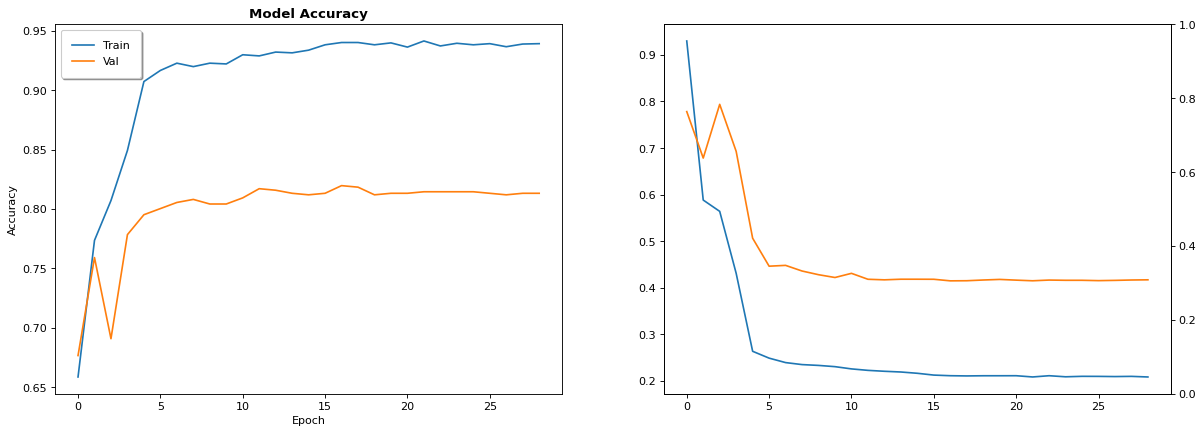

In [24]:
model_filepath = '/kaggle/working/XLNET.epoch{epoch:02d}.keras'
Plots_Path = '/kaggle/working/XLNET.epoch{epoch:02d}.png'
train_model(X_train, y_train_res, X_val, y_val_res, model_filepath, Plots_Path, 30, 8, False, 320, 11, 'RandomNormal', 8, 0.0001, 'SGD')

In [25]:
import pandas as pd
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, roc_curve
from tensorflow import keras
import time

%matplotlib inline

In [26]:
def display_conf_matrix(true_labels, pred_labels, pred_proba, classifier, savefile):
    
    # Display and Save Confusion Matrix:
    fig = plt.figure(figsize=(6,4), dpi=100)

    confusion_matrix1 = pd.crosstab(np.array(true_labels), 
                                   np.array(pred_labels),
                                   rownames=['Actual'], colnames=['Predicted'])
    confusion_matrix2 = pd.crosstab(np.array(true_labels), 
                                   np.array(pred_labels),
                                   rownames=['Actual'], colnames=['Predicted'], normalize='index')


    # Extracting counts and percentages from the matrices above:
    counts = ["{0:,}".format(value) for value in
                    confusion_matrix1.to_numpy().flatten()]

    percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix2.to_numpy().flatten()]

    # Combining counts and percentages as one label:
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(percentages, counts)]

    # Reshaping the labels to fit the array:
    labels = np.asarray(labels).reshape(2,2)

    #Plotting the heatmap:
    sns.heatmap(confusion_matrix2, annot=labels, fmt='', cmap='BuPu')
    plt.title("Confusion Matrix - %s\n" % classifier, fontweight='bold')
    plt.savefig(savefile, bbox_inches='tight')
    plt.show()

    # Calculating Metrics Using the Confusion Matrix:
    CM = confusion_matrix(true_labels, pred_labels, labels=[0, 1])

    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]
    TN = CM[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print(f"Sensitivity:     {TPR*100:.2f}%")
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print(f"Specificity:     {TNR*100:.2f}%")
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print(f"Accuracy:        {ACC*100:.2f}%") 

    # f1 Score:
    F1 = TP/(TP + (0.5*(FP+FN)))
    print(f"F1 Score:        {F1*100:.2f}%") 

    MCC = ((TP*TN)-(FP*FN))/ (((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))**0.5)
    print(f"MCC:             {MCC*100:.2f}%") 
    
    auROC = roc_auc_score(true_labels, pred_proba)
    print(f"auROC:           {auROC*100:.2f}%") 
    
    metrics = [TPR*100, TNR*100, ACC*100, F1*100, MCC*100, auROC*100]

    return metrics

In [27]:
def convert_preds(preds):
  model_preds = np.concatenate(np.round(preds), axis=0).tolist()
  df = pd.DataFrame({'pred_labels': model_preds})
  pred_labels = df.pred_labels

  return pred_labels

In [28]:
def load_X_Test_data(lang_model):
  if lang_model =='BERT':
    print("bert")
    X_test = np.load('/kaggle/working/BERT_EMBED_X_TEST.npy')
  elif lang_model =='BERT_BFD':
    print("here")
    X_test = np.load('/kaggle/working/BERT_BFD_EMBED_X_TEST.npy')
  elif lang_model =='T5XL_UNI':
    print("here")
    X_test = np.load('/kaggle/working/T5XL_UNI_EMBED_X_TEST.npy')
  elif lang_model =='T5XL_UNI_INDEP':
    X_test = np.load('Embeddings/T5XL_UNI/T5XL_UNI_VELTRI_X_TEST_INDEP.npy')
  elif lang_model =='T5XL_BFD':
    print("T5XL_BFD")
    X_test = np.load('/kaggle/working/T5XL_BFD_EMBED_X_TEST.npy')
  elif lang_model =='XLNET':
    print("here")
    X_test = np.load('/kaggle/working/XLNET_EMMBED_X_TEST.npy')
  elif lang_model =='VELTRI':
    X_test = np.load('Datasets/VELTRI/X_test_VELTRI_Conv.npy')
  
  
  return X_test

In [29]:
y_train = pd.DataFrame({'true_label':np.concatenate(np.round(y_train), axis=0).tolist()}).true_label
y_val = pd.DataFrame({'true_label':np.concatenate(np.round(y_val), axis=0).tolist()}).true_label
y_test = pd.DataFrame({'true_label':np.concatenate(np.round(y_test), axis=0).tolist()}).true_label

In [30]:
X_test = load_X_Test_data('XLNET')

here


In [31]:
X_test.shape

(990, 100, 1024)

In [32]:
X_train = X_train.reshape(X_train.shape[0], 100, 1024, 1)
X_val = X_val.reshape(X_val.shape[0], 100, 1024, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 1024, 1)

In [33]:
X_train.shape

(3104, 100, 1024, 1)

In [34]:
X_val.shape

(776, 100, 1024, 1)

In [35]:
X_test.shape

(990, 100, 1024, 1)

## Testing Single Layer Model

In [82]:
t5xl_uni_model = keras.models.load_model('/kaggle/working/XLNET.epoch09.keras')

In [83]:
t5xl_uni_mod_pred = t5xl_uni_model.predict(X_test, batch_size=8)

124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


In [84]:
t5xl_uni_mod_pred_labels = convert_preds(t5xl_uni_mod_pred)

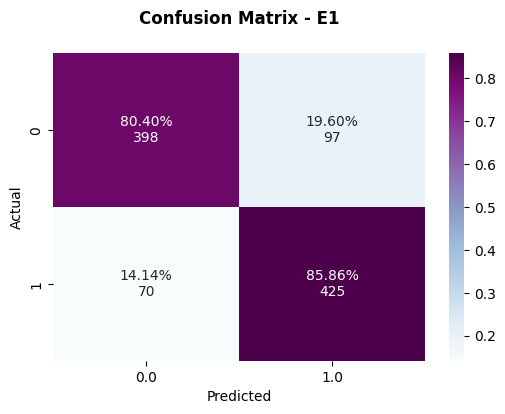

Sensitivity:     85.86%
Specificity:     80.40%
Accuracy:        83.13%
F1 Score:        83.58%
MCC:             66.36%
auROC:           90.97%


In [85]:
t5xl_uni_metrics = display_conf_matrix(y_test, t5xl_uni_mod_pred_labels, t5xl_uni_mod_pred, 'E1', '/kaggle/working/XLNET_Model_CM.png')

## Create Prob Dataframes

In [87]:
best_model = keras.models.load_model('/kaggle/working/XLNET.epoch09.keras')

In [88]:
train_mod_pred = best_model.predict(X_train, batch_size=8)
val_mod_pred = best_model.predict(X_val, batch_size=8)
test_mod_pred = best_model.predict(X_test, batch_size=8)

388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


In [89]:
def create_results_dataframe(data, labels):
    # Convert train_mod_pred to a 1D array if it's not already
    positive_prob = data.flatten()
    
    # Ensure y_train is also a 1D array (or Series)
    true_label = labels
    
    # Create a DataFrame
    results_df = pd.DataFrame({
        'positive_prob': positive_prob,
        'true_label': true_label
    })
    
    return results_df

In [90]:
train_df = create_results_dataframe(train_mod_pred, y_train)
val_df = create_results_dataframe(val_mod_pred, y_val)
test_df = create_results_dataframe(test_mod_pred, y_test)

In [91]:
combined_df = pd.concat([train_df, val_df], ignore_index=True)
combined_df

,positive_prob,true_label
0,0.944184,1
1,0.956916,1
2,0.034988,0
3,0.115635,0
4,0.994937,1
...,...,...
3875,0.429026,0
3876,0.227522,0
3877,0.697898,0
3878,0.176784,0


In [92]:
test_df

,positive_prob,true_label
0,0.877655,0
1,0.029767,0
2,0.361398,0
3,0.136520,0
4,0.005355,0
...,...,...
985,0.868459,1
986,0.876021,1
987,0.970253,1
988,0.802487,1


In [93]:
combined_df.to_csv('predneuro_xlnet_train.csv', index=False)
test_df.to_csv('predneuro_xlnet_test.csv', index=False)